#####  **Import Required Libraries**

In [1354]:
import matplotlib.pyplot as plt
from scipy import stats

import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


#### **Load Data**

In [1355]:
file_path = "../resources/data/output/online_retail_kmeans.csv"
df = pd.read_csv(file_path)

In [1356]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


In [1357]:
df.shape

(392689, 9)

In [1358]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [1359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392689 entries, 0 to 392688
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392689 non-null  int64         
 1   StockCode    392689 non-null  object        
 2   Description  392689 non-null  object        
 3   Quantity     392689 non-null  int64         
 4   InvoiceDate  392689 non-null  datetime64[ns]
 5   UnitPrice    392689 non-null  float64       
 6   CustomerID   392689 non-null  float64       
 7   Country      392689 non-null  object        
 8   TotalPrice   392689 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 27.0+ MB


In [1360]:
df.drop(['InvoiceDate','CustomerID', 'InvoiceNo'], axis=1).describe()

,Quantity,UnitPrice,TotalPrice
count,392689.000000,392689.000000,392689.000000
mean,12.724400,3.124276,21.906867
std,43.083634,22.217990,74.172664
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,4800.000000,8142.750000,8142.750000


#### **RFM Analysis**

**Standardize Data**

In [1337]:
def standardize_data(data, method):
    """
    Standardizes the data using the specified scaler.

    Parameters:
    data (DataFrame): The input data to standardize.
    method (str): The scaling method ('MIN_MAX', 'STANDARD', 'ROBUST').

    Returns:
    DataFrame: The standardized data.
    """
    try:
        # Check if the input data is a pandas DataFrame
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame.")

        # Check if the DataFrame contains the expected columns
        required_columns = ["XformRecency", "XformFrequency", "XformMonetary"]
        if not all(column in data.columns for column in required_columns):
            raise ValueError(
                "DataFrame must contain 'XformRecency', 'XformFrequency', "
                "and 'XformMonetary' columns."
            )

        # Check if the data is numeric
        if not pd.api.types.is_numeric_dtype(data["XformMonetary"]) or \
           not pd.api.types.is_numeric_dtype(data["XformFrequency"]) or \
           not pd.api.types.is_numeric_dtype(data["XformRecency"]):
            raise ValueError("Data must be numeric.")

        # Select the appropriate scaler
        if method == 'MIN_MAX':
            scaler = MinMaxScaler()
        elif method == 'STANDARD':
            scaler = StandardScaler()
        else:
            scaler = RobustScaler()

        # Fit the model to the data and transform the data
        data[["XformRecency", "XformFrequency", "XformMonetary"]] = scaler.fit_transform(
            data[["XformRecency", "XformFrequency", "XformMonetary"]]
        )

        return data

    except Exception as e:
        print(f"Failed to standardize data: {e}")


**Calculate RFM values**

In [1338]:
def calculate_rfm(data):
    """
    Calculates the RFM values for each customer.

    Parameters:
    data (DataFrame): The input data containing invoice information.

    Returns:
    DataFrame: A DataFrame with calculated RFM metrics.
    """
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

    # Calculate Recency (R)
    data['Recency'] = (
        (data['InvoiceDate'].max() - 
         data.groupby('CustomerID')['InvoiceDate'].transform('max'))
        .dt.days
    )

    # Calculate Frequency (F)
    data_freq = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
    data_freq.columns = ['CustomerID', 'Frequency']

    # Calculate Monetary (M)
    data['TotalSpent'] = data['Quantity'] * data['UnitPrice']
    data_monet = data.groupby('CustomerID')['TotalSpent'].sum().reset_index()
    data_monet.columns = ['CustomerID', 'Monetary']

    # Merge all metrics
    rfm_df = data_freq.merge(data_monet, on='CustomerID')
    rfm_df['Recency'] = data['Recency'].groupby(data['CustomerID']).max().values

    rfm_df['XformRecency'] = rfm_df['Recency']
    rfm_df['XformFrequency'] = rfm_df['Frequency']

    # Logarithmic transformation
    rfm_df['XformMonetary'] = np.log1p(rfm_df['Monetary'])

    # Calculate the RFM score
    rfm_df['RFM'] = (
        rfm_df['XformRecency'] + 
        rfm_df['XformFrequency'] + 
        rfm_df['XformMonetary']
    )

    return rfm_df


In [1339]:
# Calculate the RFM metrics for the dataset 'df'
rfm_df = calculate_rfm(df)

# Display the calculated RFM DataFrame
rfm_df.head()


,CustomerID,Frequency,Monetary,Recency,XformRecency,XformFrequency,XformMonetary,RFM
0,12347.0,182,4310.00,40,40,182,8.368925,230.368925
1,12348.0,31,1797.24,76,76,31,7.494564,114.494564
2,12349.0,73,1757.55,19,19,73,7.472245,99.472245
3,12350.0,17,334.40,311,311,17,5.815324,333.815324
4,12352.0,85,2506.04,73,73,85,7.826858,165.826858


In [1340]:
# Standardize data
rfm_df = standardize_data(rfm_df, method='ROBUST')

**Plot RFM distribution**

In [1341]:
rfm_df.head()

,CustomerID,Frequency,Monetary,Recency,XformRecency,XformFrequency,XformMonetary,RFM
0,12347.0,182,4310.00,40,-0.150000,1.740741,1.106371,230.368925
1,12348.0,31,1797.24,76,0.107143,-0.123457,0.586978,114.494564
2,12349.0,73,1757.55,19,-0.300000,0.395062,0.573720,99.472245
3,12350.0,17,334.40,311,1.785714,-0.296296,-0.410532,333.815324
4,12352.0,85,2506.04,73,0.085714,0.543210,0.784369,165.826858


In [1342]:
rfm_df.describe()

,CustomerID,Frequency,Monetary,Recency,XformRecency,XformFrequency,XformMonetary,RFM
count,4337.000000,4337.000000,4337.000000,4337.000000,4337.000000,4337.000000,4337.000000,4337.000000
mean,15301.089232,90.543924,1983.533709,105.447083,0.317479,0.611653,0.046177,202.575171
std,1721.422291,225.529052,8528.168626,115.056550,0.821833,2.784309,0.745441,233.387767
min,12347.000000,1.000000,2.900000,0.000000,-0.435714,-0.493827,-3.056525,6.575947
25%,13814.000000,17.000000,306.450000,22.000000,-0.278571,-0.296296,-0.462219,96.062851
50%,15300.000000,41.000000,668.430000,61.000000,0.000000,0.000000,0.000000,163.927303
75%,16779.000000,98.000000,1654.310000,162.000000,0.721429,0.703704,0.537781,261.582925
max,18287.000000,7676.000000,280206.020000,697.000000,4.542857,94.259259,3.586044,7686.609572


**Data Distribution Using Histogram**

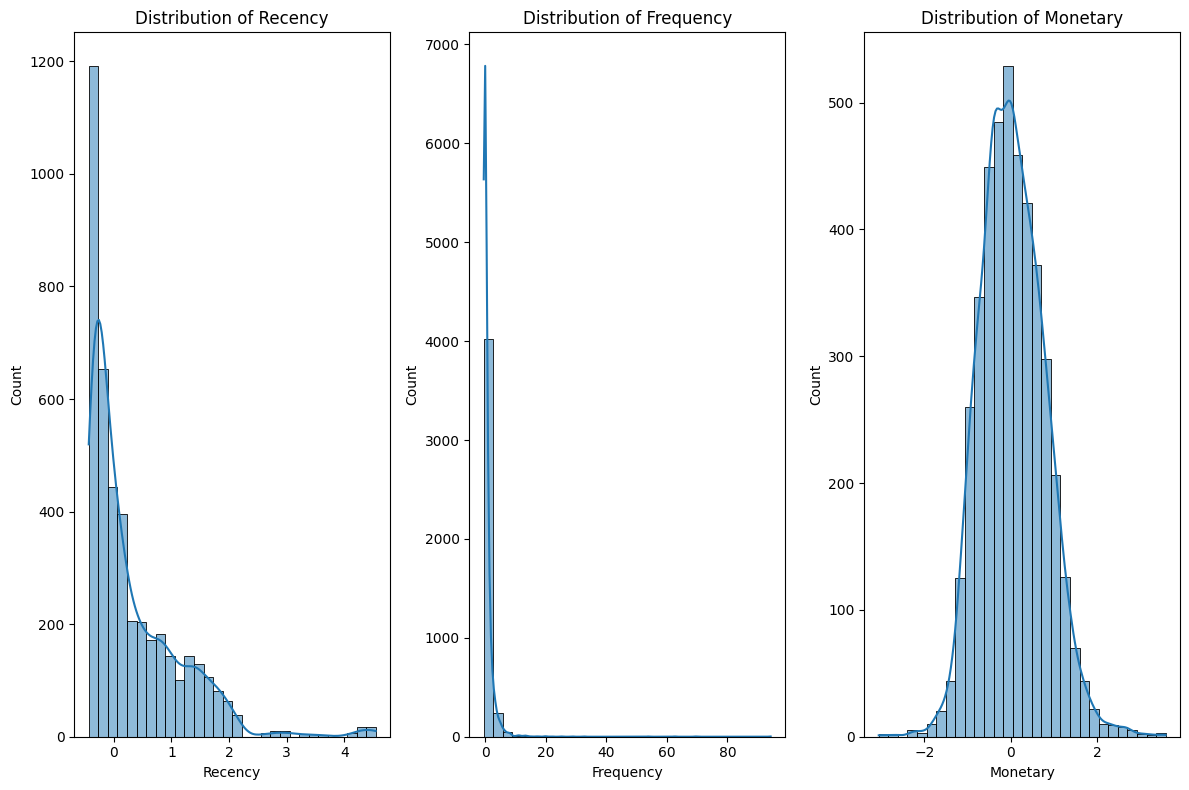

In [1343]:
columns = ['XformRecency', 'XformFrequency', 'XformMonetary']
plt.figure(figsize=(12, 8))

for i, col in enumerate(columns):
    plt.subplot(1, 3, i + 1)  
    sns.histplot(rfm_df[col], bins=30, kde=True)
    
    col_name = col.split('Xform')[1]
    plt.xlabel(col_name)
    plt.title(f"Distribution of {col_name}")

plt.tight_layout()
plt.show()


Recency Distribution: Skewed towards low Recency values, indicating most customers have engaged recently, which is favorable for retention.

Frequency Distribution: Displays a long tail, suggesting a small subset of highly active customers, while most show moderate engagement.

Monetary Distribution: Normalized distribution centered around zero, balancing high and low spenders, enabling accurate modeling.

**Check Correlation for Clustering**

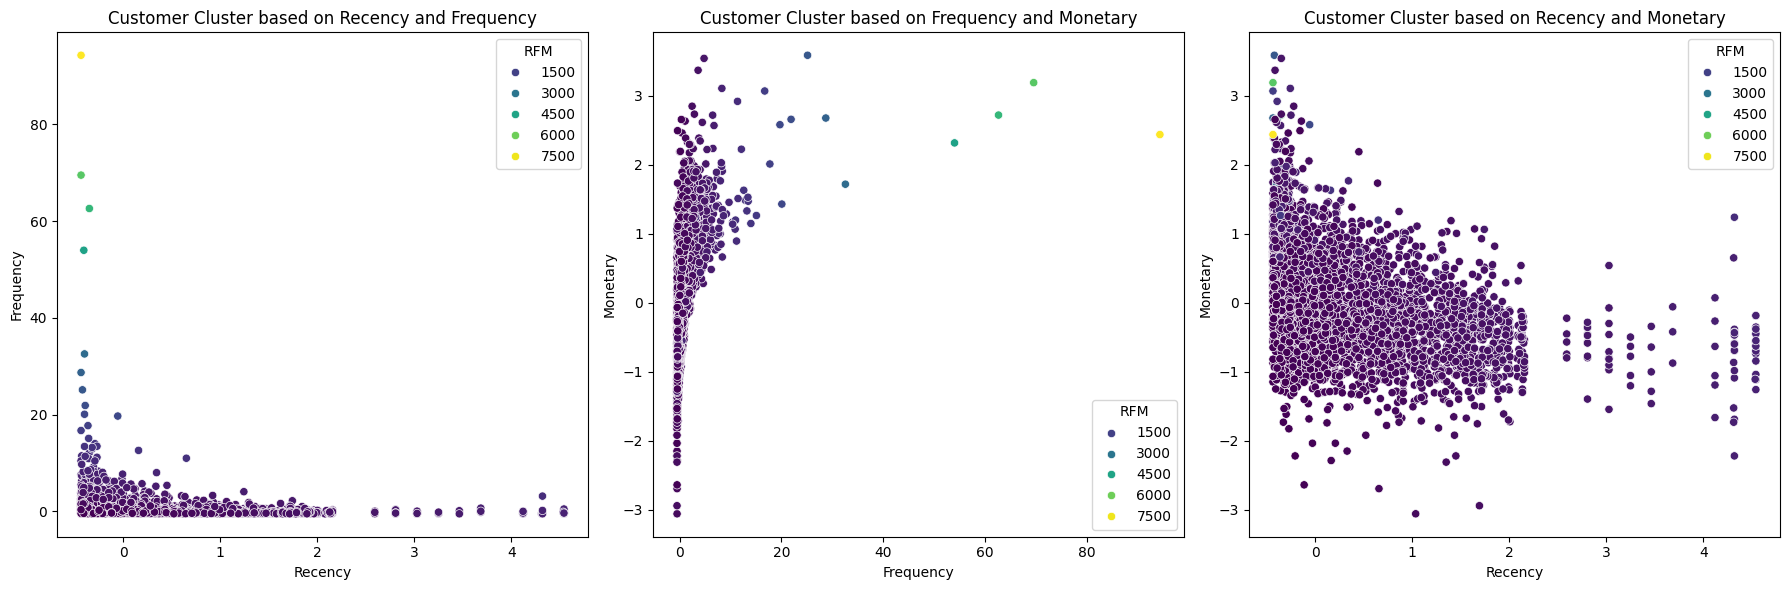

In [1344]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Scatter plot for Recency vs Frequency
sns.scatterplot(x='XformRecency', y='XformFrequency', hue='RFM', data=rfm_df, palette='viridis', ax=axes[0])
axes[0].set_title('Customer Cluster based on Recency and Frequency')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')

# Scatter plot for Frequency vs Monetary
sns.scatterplot(x='XformFrequency', y='XformMonetary', hue='RFM', data=rfm_df, palette='viridis', ax=axes[1])
axes[1].set_title('Customer Cluster based on Frequency and Monetary')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Monetary')

# Scatter plot for Recency vs Monetary
sns.scatterplot(x='XformRecency', y='XformMonetary', hue='RFM', data=rfm_df, palette='viridis', ax=axes[2])
axes[2].set_title('Customer Cluster based on Recency and Monetary')
axes[2].set_xlabel('Recency')
axes[2].set_ylabel('Monetary')

plt.tight_layout() 
plt.show()

Recency vs. Frequency: Inverse relationship; recent customers tend to engage more frequently.

Frequency vs. Monetary: Positive correlation; frequent customers often contribute higher monetary value.

Recency vs. Monetary: Minimal correlation; recent customers are not always high spenders.

**Visualize Customer Segmentation based on RFM score**

In [1345]:
def visualize_clusters_3d(data):
    """Visualize the clusters in 3D."""
    fig = px.scatter_3d(
        data, 
        x='XformRecency', 
        y='XformFrequency', 
        z='XformMonetary', 
        color='RFM', 
        title='Customer Clustering using RFM Score',
        labels={
            'XformRecency': 'Recency',     
            'XformFrequency': 'Frequency',   
            'XformMonetary': 'Monetary',    
            'RFM': 'RFM Score'
        },
        hover_name='CustomerID'
    )
    
    fig.show()


In [1346]:
visualize_clusters_3d(rfm_df)

The above 3D scatter plot reveals four key customer segments based on ***RFM scores***:

1. High-Value Customers (Top RFM Scores, Bright Yellow) – Frequent, recent buyers with high spending.

2. Loyal Customers (Medium-High RFM, Orange) – Moderate spenders who purchase regularly.

3. At-Risk Customers (Medium-Low RFM, Purple-Orange Transition) – Previously active but declining engagement.

4. Lost Customers (Low RFM, Dark Purple) – Infrequent buyers with low spending, needing re-engagement.


#### **Write output for Clustering implementation**

In [1347]:
rfm_df.to_csv('../resources/data/output/online_retail_rfm_kmeans.csv', index=False)